In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('..')

import dotenv
dotenv.load_dotenv('../.env')
import cv2
import boto3
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.spatial

from api.io import VideoIO

In [ ]:
def get_labels(rekog, frame):
    frame_bytes = cv2.imencode('.jpg', frame)[1].tobytes()
    response = rekog.detect_labels(Image={'Bytes': frame_bytes})
    return response['Labels']

def to_abs(bounding_box, w, h):
    top = bounding_box['Top']
    left = bounding_box['Left']
    width = bounding_box['Width']
    height = bounding_box['Height']

    top *= h
    left *= w
    width *= w
    height *= h

    return {
        'top': int(top),
        'left': int(left),
        'width': int(width),
        'height': int(height)
    }

def to_rect(bbox):
    top_left = (bbox['left'], bbox['top'])
    bottom_right = (bbox['left'] + bbox['width'], bbox['top'] + bbox['height'])

    return (top_left, bottom_right)
    
def draw_rekog(frame, labels):
    display = frame.copy()
    h, w = display.shape[:2]
    for label in labels:
        name = label['Name']
        for instance in label['Instances']:
            bbox = instance.get('BoundingBox')
            conf = instance.get('Confidence')
            abs_bbox = to_abs(bbox, h, w)
            rect = to_rect(abs_bbox)
            cv2.putText(display, name + ' {:.1f}'.format(conf), rect[0], cv2.FONT_HERSHEY_PLAIN, 3, 255, 4)
            cv2.rectangle(display, rect[0], rect[1], (0,255,0), 3)
    return display

def draw_rects(frame, rects):
    display = frame.copy()
    for rect in rects:
#         cv2.putText(display, name + ' {:.1f}'.format(conf), rect[0], cv2.FONT_HERSHEY_PLAIN, 3, 255, 4)
        cv2.rectangle(display, rect[0], rect[1], (0,255,0), 3)
    return display

In [3]:
rekog = boto3.client(
            'rekognition', 
             aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
             aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
             region_name=os.getenv('AWS_DEFAULT_REGION')
        )

In [4]:
vid = VideoIO('../../data/VID_20190824_114244.mp4')

In [5]:
frame = vid.get_frame(800)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = cv2.rotate(frame, cv2.ROTATE_180)

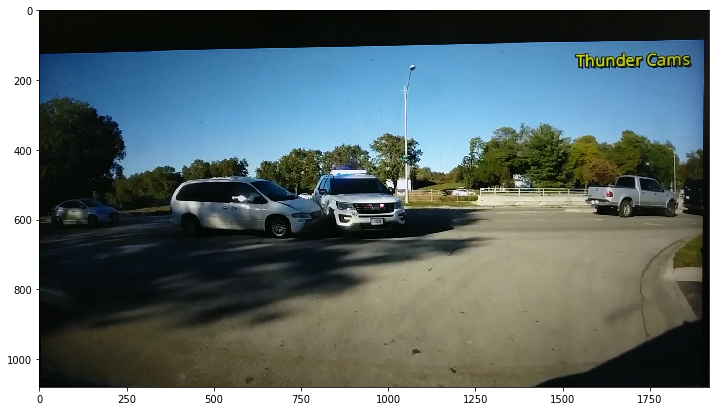

In [6]:
plt.figure(figsize=(12, 12))
plt.imshow(frame)

In [7]:
labels = get_labels(rekog, frame)

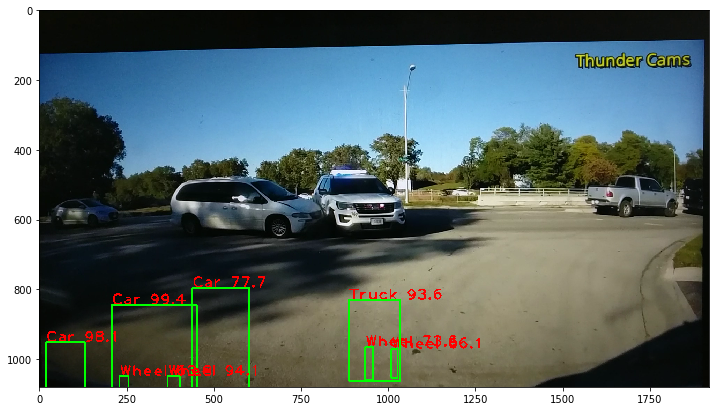

In [8]:
display = draw_rekog(frame, labels)
plt.figure(figsize=(12, 12))
plt.imshow(display)

In [9]:
bf = cv2.BFMatcher()
orb = cv2.ORB_create()

In [10]:
def gen_descriptors(orb, frame):    
    kp, des = orb.detectAndCompute(frame,None)
    return des

def extract_features(image, vector_size=32):
    image = cv2.resize(image, (int(image.shape[0]*2),int(image.shape[1]*2)))
    # Using KAZE, cause SIFT, ORB and other was moved to additional module
    # which is adding addtional pain during install
    alg = cv2.ORB_create()
    # Dinding image keypoints
    kps = alg.detect(image)
    
    # Getting first 32 of them. 
    # Number of keypoints is varies depend on image size and color pallet
    # Sorting them based on keypoint response value(bigger is better)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    # computing descriptors vector
    kps, dsc = alg.compute(image, kps)
    
    # Flatten all of them in one big vector - our feature vector
    dsc = dsc.flatten()
    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (vector_size * 64)
    if dsc.size < needed_size:
        # if we have less the 32 descriptors then just adding zeros at the
        # end of our feature vector
        dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])

    return dsc

def compute_similarity(im1, im2):
    v1 = extract_features(im1)
    v2 = extract_features(im2)
    cos_dist = scipy.spatial.distance.cdist(v1.reshape(1, -1), v2.reshape(1, -1), 'cosine').squeeze(0)
    return 1 - cos_dist

In [11]:
compute_similarity(frames[610], frames[600])

NameError: name 'frames' is not defined

In [12]:
frames = {}
des = []
matches = []

prev_fnum = None
for fnum in [600, 610, 200]:
    frames[fnum] = vid.get_frame(fnum)
    frames[fnum] = cv2.cvtColor(frames[fnum], cv2.COLOR_BGR2RGB)
    frames[fnum] = cv2.rotate(frames[fnum], cv2.ROTATE_180)
    
    kp, desc = orb.detectAndCompute(frame, None)
    desc = desc.flatten()
    des.append(desc)

In [13]:
v1 = extract_features(frames[600], orb)
v2 = extract_features(frames[610], orb)
v3 = extract_features(frames[200], orb)

TypeError: slice indices must be integers or None or have an __index__ method

In [14]:
def cos_cdist(v1, v2):
    return scipy.spatial.distance.cdist(v1.reshape(1, -1), v2.reshape(1, -1), 'cosine').squeeze(0)

In [15]:
print(cos_cdist(v1, v2))
print(cos_cdist(v1, v3))
print(cos_cdist(v2, v3))

NameError: name 'v1' is not defined

In [16]:
class Detection():
    def __init__(self, cls, bbox, img):
        self.cls = cls
        self.bbox = bbox
        self.img = img
        self.area = bbox[2] * bbox[3]
    
    def is_inside(self, bbox):
        # (x,y,w,h)
        if self.bbox[0] >= bbox[0]:
            return False
        
        if self.bbox[1] >= bbox[1]:
            return False
        
        if self.bbox[0]+self.bbox[2] <= bbox[0]+bbox[2]:
            return False
        
        if self.bbox[1]+self.bbox[3] <= bbox[1]+bbox[3]:
            return False
        
        return True

In [24]:
SELECTED_LABELS = ['car', 'license plate']

frame_detections = []

names = set()

vid = VideoIO('../../data/backin-1.mp4')

interval = 30

frame = vid.next_frame()
h, w = frame.shape[:2]

frame_count = 0

cv2.namedWindow('frame', cv2.WINDOW_KEEPRATIO)
while(True):
    frame = vid.next_frame()
    
    if frame is None:
        break
    
    if frame_count % interval == 0:
        labels = get_labels(rekog, frame)
        
        bboxes = []
        
        display = frame.copy()
        
        frame_detections.append([])
        for label in labels:
            name = label['Name']
            if name.lower() in SELECTED_LABELS:
                for instance in label['Instances']:
                    bbox = instance.get('BoundingBox')
                    conf = instance.get('Confidence')
                    bbox = to_abs(bbox, w, h)
                    bbox = (bbox['left'], bbox['top'], bbox['width'], bbox['height'])
                    bboxes.append(bbox)
                    
                    p1 = (int(bbox[0]), int(bbox[1]))
                    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
                    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 4)
                    
                    crop = frame[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]
                    
                    det = Detection(name, bbox, crop)
                    frame_detections[-1].append(det)
        
        cv2.imshow('frame', display)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    frame_count += 1

vid.close()
cv2.destroyAllWindows()

In [25]:
def find_parent_child(frame_dets):
    pairs = []
    for dets in frame_dets:
        for i, _ in enumerate(dets):
            for j, _ in enumerate(dets[i+1:]):
                if dets[i].cls.lower() == 'car' and dets[j].cls.lower() == 'license plate':
                    if dets[i].is_inside(dets[j].bbox):
                        pairs.append((dets[i], dets[j]))
    return pairs

In [26]:
pairs = find_parent_child(frame_detections)

In [27]:
for i, pair in enumerate(pairs):
    for k, det in enumerate(pair):
        fname = 'tmp/{}-{}.jpg'.format(i, 'ab'[k])
        cv2.imwrite(fname, det.img)

In [28]:
target = sorted(pairs, key=lambda x: x[0].area, reverse=True)[0]

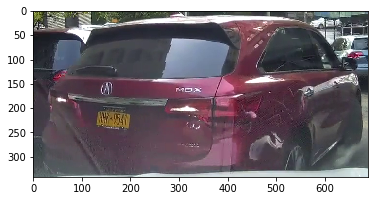

In [35]:
imrgb = cv2.cvtColor(target[0].img, cv2.COLOR_BGR2RGB)
plt.imshow(imrgb)

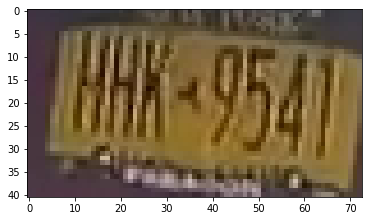

In [51]:
imrgb = cv2.cvtColor(target[1].img, cv2.COLOR_BGR2RGB)
plt.imshow(imrgb)

In [36]:
frame_bytes = cv2.imencode('.jpg', cv2.cvtColor(target[1].img, cv2.COLOR_BGR2RGB))[1].tobytes()
response = rekog.detect_text(Image={'Bytes': frame_bytes})

In [37]:
response

{'TextDetections': [{'DetectedText': 'UHN-954U 9541',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 87.8521957397461,
   'Geometry': {'BoundingBox': {'Width': 1.000661849975586,
     'Height': 0.8804432153701782,
     'Left': -0.0006636423640884459,
     'Top': 0.04878207668662071},
    'Polygon': [{'X': -0.0006636423640884459, 'Y': 0.04878207668662071},
     {'X': 0.9999982118606567, 'Y': 0.04638445004820824},
     {'X': 1.0006636381149292, 'Y': 0.9268276691436768},
     {'X': 1.810963681236899e-06, 'Y': 0.9292253255844116}]}},
  {'DetectedText': 'UHN-954U',
   'Type': 'WORD',
   'Id': 1,
   'ParentId': 0,
   'Confidence': 81.44110870361328,
   'Geometry': {'BoundingBox': {'Width': 1.0,
     'Height': 0.8780487775802612,
     'Left': 0.0,
     'Top': 0.04878048598766327},
    'Polygon': [{'X': 0.0, 'Y': 0.04878048598766327},
     {'X': 1.0, 'Y': 0.04878048598766327},
     {'X': 1.0, 'Y': 0.9268292784690857},
     {'X': 0.0, 'Y': 0.9268292784690857}]}},
  {'DetectedText': '9541',
   

Bar 1
  RGB values: (76, 62, 71)
  HSV values: (161, 47, 76)
Bar 2
  RGB values: (105, 86, 94)
  HSV values: (167, 46, 105)
Bar 3
  RGB values: (47, 46, 53)
  HSV values: (124, 34, 53)
Bar 4
  RGB values: (148, 138, 153)
  HSV values: (140, 25, 153)
Bar 5
  RGB values: (221, 223, 226)
  HSV values: (108, 6, 226)


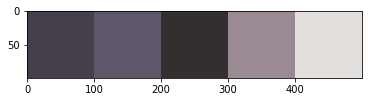

In [38]:
from sklearn.cluster import KMeans


def make_histogram(cluster):
    """
    Count the number of pixels in each cluster
    :param: KMeans cluster
    :return: numpy histogram
    """
    numLabels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    hist, _ = np.histogram(cluster.labels_, bins=numLabels)
    hist = hist.astype('float32')
    hist /= hist.sum()
    return hist


def make_bar(height, width, color):
    """
    Create an image of a given color
    :param: height of the image
    :param: width of the image
    :param: BGR pixel values of the color
    :return: tuple of bar, rgb values, and hsv values
    """
    bar = np.zeros((height, width, 3), np.uint8)
    bar[:] = color
    red, green, blue = int(color[2]), int(color[1]), int(color[0])
    hsv_bar = cv2.cvtColor(bar, cv2.COLOR_BGR2HSV)
    hue, sat, val = hsv_bar[0][0]
    return bar, (red, green, blue), (hue, sat, val)


def sort_hsvs(hsv_list):
    """
    Sort the list of HSV values
    :param hsv_list: List of HSV tuples
    :return: List of indexes, sorted by hue, then saturation, then value
    """
    bars_with_indexes = []
    for index, hsv_val in enumerate(hsv_list):
        bars_with_indexes.append((index, hsv_val[0], hsv_val[1], hsv_val[2]))
    bars_with_indexes.sort(key=lambda elem: (elem[1], elem[2], elem[3]))
    return [item[0] for item in bars_with_indexes]


# reshape the image to be a simple list of RGB pixels
image = target[0].img.reshape(-1, 3)

# we'll pick the 5 most common colors
num_clusters = 5
clusters = KMeans(n_clusters=num_clusters)
clusters.fit(image)

# count the dominant colors and put them in "buckets"
histogram = make_histogram(clusters)
# then sort them, most-common first
combined = zip(histogram, clusters.cluster_centers_)
combined = sorted(combined, key=lambda x: x[0], reverse=True)

# finally, we'll output a graphic showing the colors in order
bars = []
hsv_values = []
for index, rows in enumerate(combined):
    bar, rgb, hsv = make_bar(100, 100, rows[1])
    print(f'Bar {index + 1}')
    print(f'  RGB values: {rgb}')
    print(f'  HSV values: {hsv}')
    hsv_values.append(hsv)
    bars.append(bar)

# sort the bars[] list so that we can show the colored boxes sorted
# by their HSV values -- sort by hue, then saturation
sorted_bar_indexes = sort_hsvs(hsv_values)
sorted_bars = [bars[idx] for idx in sorted_bar_indexes]

plt.imshow(np.hstack(bars))

In [40]:
SELECTED_LABELS = ['car', 'license plate']

frame_detections = []

names = set()

vid = VideoIO('../../data/collision-2.mp4')

interval = 30

frame = vid.next_frame()
frame = cv2.rotate(frame, cv2.ROTATE_180)
h, w = frame.shape[:2]

frame_count = 0

cv2.namedWindow('frame', cv2.WINDOW_KEEPRATIO)
while(True):
    frame = vid.next_frame()
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    
    if frame is None:
        break
    
    if frame_count % interval == 0:
        labels = get_labels(rekog, frame)
        
        bboxes = []
        
        display = frame.copy()
        
        frame_detections.append([])
        for label in labels:
            name = label['Name']
            if name.lower() in SELECTED_LABELS:
                for instance in label['Instances']:
                    bbox = instance.get('BoundingBox')
                    conf = instance.get('Confidence')
                    bbox = to_abs(bbox, w, h)
                    bbox = (bbox['left'], bbox['top'], bbox['width'], bbox['height'])
                    bboxes.append(bbox)
                    
                    p1 = (int(bbox[0]), int(bbox[1]))
                    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
                    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 4)
                    
                    crop = frame[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]
                    
                    det = Detection(name, bbox, crop)
                    frame_detections[-1].append(det)
        
        cv2.imshow('frame', display)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    frame_count += 1

vid.close()
cv2.destroyAllWindows()

In [46]:
def get_surrounding_box(bbox1, bbox2):
    left = min(bbox1[0], bbox2[0])
    top = min(bbox1[1], bbox2[1])
    right = max(bbox1[0]+bbox1[2], bbox2[0]+bbox2[2])
    bottom = max(bbox1[1]+bbox1[3], bbox2[1]+bbox2[3])
    return (left, top, right-left, bottom-top)

In [41]:
colliders = sorted(frame_detections[-1], key=lambda x: x.area, reverse=True)[:2]

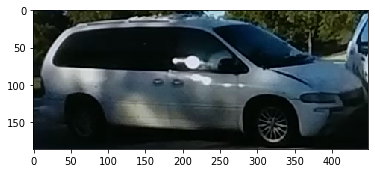

In [49]:
plt.imshow(cv2.cvtColor(colliders[0].img, cv2.COLOR_BGR2RGB))

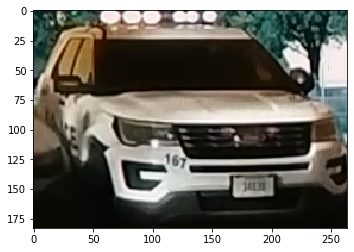

In [45]:
plt.imshow(cv2.cvtColor(colliders[1].img, cv2.COLOR_BGR2RGB))

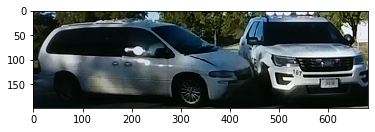

In [50]:
big_box = get_surrounding_box(colliders[0].bbox, colliders[1].bbox)
crash_crop = frame[big_box[1]:big_box[1]+big_box[3], big_box[0]:big_box[0]+big_box[2], :]
plt.imshow(cv2.cvtColor(crash_crop, cv2.COLOR_BGR2RGB))

In [33]:
cv2.destroyAllWindows()

In [189]:
# fig, ax = plt.subplots(ncols=3, nrows=len(car_imgs)//3, figsize=(40, 40))

prev_car = None
for idx, car in enumerate(car_imgs):
    if prev_car is not None:
        try:
            sim = compute_similarity(prev_car, car)
            fname = 'tmp/' + str(idx) + '-' + 'AAA' + '-' + str(sim[0]) + '.jpg'
            cv2.imwrite(fname, car)
            fname = 'tmp/' +str(idx) + '-' + 'BBB' + '-' + str(sim[0]) + '.jpg'
            cv2.imwrite(fname, prev_car)
        except AttributeError:
            continue
    prev_car = car

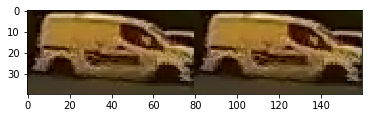

In [164]:
plt.imshow(np.hstack([car, prev_car]))

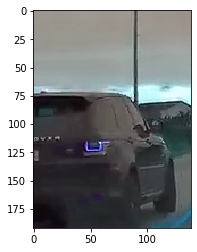

In [44]:
plt.imshow(car_imgs[1])

In [212]:
names


{'Aircraft',
 'Airplane',
 'Asphalt',
 'Automobile',
 'Bridge',
 'Building',
 'Bumper',
 'Bus',
 'Car',
 'City',
 'Freeway',
 'Grand Theft Auto',
 'Highway',
 'Human',
 'Intersection',
 'License Plate',
 'Light',
 'Machine',
 'Metropolis',
 'Moving Van',
 'Overpass',
 'Pedestrian',
 'Person',
 'Plant',
 'Road',
 'Sedan',
 'Street',
 'Tarmac',
 'Town',
 'Traffic Light',
 'Trailer Truck',
 'Train',
 'Transportation',
 'Tree',
 'Truck',
 'Urban',
 'Van',
 'Vehicle',
 'Wheel',
 'Zebra Crossing'}

In [194]:
labels

[{'Name': 'Automobile',
  'Confidence': 99.4404525756836,
  'Instances': [],
  'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]},
 {'Name': 'Transportation',
  'Confidence': 99.4404525756836,
  'Instances': [],
  'Parents': []},
 {'Name': 'Car',
  'Confidence': 99.4404525756836,
  'Instances': [{'BoundingBox': {'Width': 0.22643007338047028,
     'Height': 0.1675073355436325,
     'Left': 0.19307683408260345,
     'Top': 0.4400027096271515},
    'Confidence': 99.4404525756836},
   {'BoundingBox': {'Width': 0.103291817009449,
     'Height': 0.08153855800628662,
     'Left': 0.018861079588532448,
     'Top': 0.49533340334892273},
    'Confidence': 98.05194854736328},
   {'BoundingBox': {'Width': 0.15125322341918945,
     'Height': 0.1805296689271927,
     'Left': 0.4070170521736145,
     'Top': 0.41424769163131714},
    'Confidence': 77.69136810302734}],
  'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]},
 {'Name': 'Vehicle',
  'Confidence': 99.4404525756836,
  'I

In [ ]:
car_imgs = []

VEHICLES = ['car', 'truck', 'bus', 
            'van', 'machine', 'moving van', 
            'trailer truck', 'vehicle']

names = set()

vid = VideoIO('../../data/speeding.mp4')

interval = 10

frame = vid.next_frame()
h, w = frame.shape[:2]

frame_count = 0

cv2.namedWindow('frame', cv2.WINDOW_KEEPRATIO)
while(True):
    frame = vid.next_frame()
    
    if frame is None:
        break
    
    if frame_count % interval == 0:
        labels = get_labels(rekog, frame)
        
        bboxes = []
        
        for label in labels:
            name = label['Name']
            names.add(name)
            if name.lower() in VEHICLES:
                for instance in label['Instances']:
                    bbox = instance.get('BoundingBox')
                    conf = instance.get('Confidence')
                    bbox = to_abs(bbox, w, h)
                    bbox = (bbox['left'], bbox['top'], bbox['width'], bbox['height'])
                    bboxes.append(bbox)
                    
                    if conf > 0.9:
                        car_crop = frame[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]
                        car_imgs.append(car_crop)
        
        display = frame.copy()
        for i, box in enumerate(bboxes):
            p1 = (int(box[0]), int(box[1]))
            p2 = (int(box[0] + box[2]), int(box[1] + box[3]))
            cv2.rectangle(display, p1, p2, 255, 2, 1)
        cv2.imshow('frame', display)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        # Create MultiTracker object
        multitracker = cv2.MultiTracker_create()

        # Initialize MultiTracker 
        for bbox in bboxes:
            bbox = tuple(np.array(bbox).flatten())
            multitracker.add(cv2.TrackerBoosting_create(), frame, bbox)
    
    # get updated location of objects in subsequent frames
    success, boxes = multitracker.update(frame)

    # draw tracked objects
    display = frame.copy()
    for i, newbox in enumerate(boxes):
        if newbox is not None:
            p1 = (int(newbox[0]), int(newbox[1]))
            p2 = (int(newbox[0]+newbox[2]), int(newbox[1]+newbox[3]))
            cv2.rectangle(display, p1, p2, 0, 2, 1)

    cv2.imshow('frame', display)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    frame_count += 1

vid.close()
cv2.destroyAllWindows()